In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import random
import torch

seed = 42

random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

import torch.nn.functional as F
import torch
from tqdm import tqdm

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0, device=device)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    
    r = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
    
    return r.to(device), noise.to(device)


# Define beta schedule
T = 512
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [2]:
from torchvision import transforms 
import torch
import torchvision
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 100

def load_transformed_dataset(path):
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Normalize(0.5, 0.5)
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.StanfordCars(root=path, download=True, 
                                         transform=data_transform)

    test = torchvision.datasets.StanfordCars(root=path, download=True, 
                                         transform=data_transform, split='test')
    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset("/cnvrg/Computer-Vision-and-Generative-AI/lesson-3-gans/exercises/solution/")
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)

In [3]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

    
@torch.no_grad()
def sample_image(image, device='cpu', forward=True):
    num_images = 16
    stepsize = int(T/num_images)
    
    imgs = []
    
    if forward:    
        for i in range(0, T, stepsize):
            t = torch.full((1,), i, device=device, dtype=torch.long)
            img, noise = forward_diffusion_sample(image, t)
            imgs.append(torch.clamp(img, -1, 1))
    
    else:
        img = image.unsqueeze(dim=0)
        for i in range(0,T)[::-1]:
            t = torch.full((1,), i, device=device, dtype=torch.long)
            img = sample_timestep(img, t)
            
            if (i % stepsize == 0) or i==0:
                imgs.append(torch.clamp(img.squeeze(dim=0), -1, 1))
    
    fig, sub = plt.subplots()
    sub.imshow(
        np.transpose(
            make_grid(
                imgs, 
                padding=0,
                normalize=True,
                nrow=8,
            ).cpu(),
            (1,2,0)
        )
    )
    _ = sub.axis("off")
    
    return fig, imgs[-1]

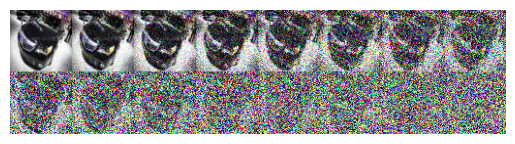

In [4]:
# Simulate forward diffusion
image = next(iter(dataloader))[0][0]
_ = sample_image(image)

In [5]:
# from torch import nn
# import math


# class Block(nn.Module):
#     def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
#         super().__init__()
#         self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
#         if up:
#             self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
#             self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
#         else:
#             self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
#             self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
#         self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
#         self.bnorm1 = nn.BatchNorm2d(out_ch)
#         self.bnorm2 = nn.BatchNorm2d(out_ch)
#         self.relu  = nn.ReLU()
        
#     def forward(self, x, t, ):
#         # First Conv
#         h = self.bnorm1(self.relu(self.conv1(x)))
#         # Time embedding
#         time_emb = self.relu(self.time_mlp(t))
#         # Extend last 2 dimensions
#         time_emb = time_emb[(..., ) + (None, ) * 2]
#         # Add time channel
#         h = h + time_emb
#         # Second Conv
#         h = self.bnorm2(self.relu(self.conv2(h)))
#         # Down or Upsample
#         return self.transform(h)


# class SinusoidalPositionEmbeddings(nn.Module):
#     def __init__(self, dim):
#         super().__init__()
#         self.dim = dim

#     def forward(self, time):
#         device = time.device
#         half_dim = self.dim // 2
#         embeddings = math.log(10000) / (half_dim - 1)
#         embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
#         embeddings = time[:, None] * embeddings[None, :]
#         embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
#         # TODO: Double check the ordering here
#         return embeddings


# class SimpleUnet(nn.Module):
#     """
#     A simplified variant of the Unet architecture.
#     """
#     def __init__(self):
#         super().__init__()
#         image_channels = 3
#         down_channels = (64, 128, 256, 512, 1024)
#         up_channels = (1024, 512, 256, 128, 64)
#         out_dim = 3 
#         time_emb_dim = 32

#         # Time embedding
#         self.time_mlp = nn.Sequential(
#                 SinusoidalPositionEmbeddings(time_emb_dim),
#                 nn.Linear(time_emb_dim, time_emb_dim),
#                 nn.ReLU()
#             )
        
#         # Initial projection
#         self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

#         # Downsample
#         self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
#                                     time_emb_dim) \
#                     for i in range(len(down_channels)-1)])
#         # Upsample
#         self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
#                                         time_emb_dim, up=True) \
#                     for i in range(len(up_channels)-1)])
        
#         # Edit: Corrected a bug found by Jakub C (see YouTube comment)
#         self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

#     def forward(self, x, timestep):
#         # Embedd time
#         t = self.time_mlp(timestep)
#         # Initial conv
#         x = self.conv0(x)
#         # Unet
#         residual_inputs = []
#         for down in self.downs:
#             x = down(x, t)
#             residual_inputs.append(x)
#         for up in self.ups:
#             residual_x = residual_inputs.pop()
#             # Add residual x as additional channels
#             x = torch.cat((x, residual_x), dim=1)           
#             x = up(x, t)
#         return self.output(x)

# model = SimpleUnet()
# print("Num params: ", sum(p.numel() for p in model.parameters()))
# #model

## Num params:  62438883

In [6]:
# !pip install 'diffusers<0.22'
# from torch import nn
# from diffusers import UNet2DModel

# class Wrapper(nn.Module):
#     def __init__(self, unet):
#         super().__init__()
#         self.unet = unet
    
#     def forward(self, *args):
#         return self.unet(*args).sample

# model = Wrapper(
#         UNet2DModel(
#         IMG_SIZE, 
#         block_out_channels=[64, 128, 256],
#         down_block_types=(
#             'DownBlock2D', 
#             'AttnDownBlock2D', 
#             'AttnDownBlock2D', 
#     #         'AttnDownBlock2D',
#     #         'AttnDownBlock2D'
#         ),
#         up_block_types= (
#             'AttnUpBlock2D', 
#             'AttnUpBlock2D', 
#     #         'AttnUpBlock2D', 
#     #         'AttnUpBlock2D',
#             'UpBlock2D'
#         )
#     )
# )
# print("Num params: ", sum(p.numel() for p in model.parameters()))

In [7]:
from unet import UNet
model = UNet(ch_mults = (1, 2, 2, 2))
print("Num params: ", sum(p.numel() for p in model.parameters()))
# # Num params:  223617155

Num params:  54563779


In [8]:
# img = torch.randn((3, IMG_SIZE, IMG_SIZE), device='cuda')
# t = torch.full((1,), 1, device='cuda', dtype=torch.long)
# model.cuda()(img.unsqueeze(dim=0).cuda(), t).shape

In [9]:
# def get_loss(model, x_0, t):
    
#     x_noisy, noise = forward_diffusion_sample(x_0, t, device)
#     noise_pred = model(x_noisy, t)
#     return F.l1_loss(noise, noise_pred)

In [10]:
# @torch.no_grad()
# def sample_plot_image():
#     # Sample noise
#     img_size = IMG_SIZE
#     img = torch.randn((1, 3, img_size, img_size), device=device)
#     plt.figure(figsize=(15,15))
#     plt.axis('off')
#     num_images = 10
#     stepsize = int(T/num_images)

#     for i in range(0,T)[::-1]:
#         t = torch.full((1,), i, device=device, dtype=torch.long)
#         img = sample_timestep(img, t)
#         # Edit: This is to maintain the natural range of the distribution
#         img = torch.clamp(img, -1.0, 1.0)
#         if i % stepsize == 0:
#             plt.subplot(1, num_images, int(i/stepsize)+1)
#             show_tensor_image(img.detach().cpu())
#     plt.show()            

In [11]:
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
base_lr = 0.0001
optimizer = Adam(model.parameters(), lr=base_lr)

In [12]:
epochs = 500 # Total number of epochs
T_max = epochs  # Number of epochs for Cosine Annealing
warmup_epochs = 20  # Number of warm-up epochs
scheduler = CosineAnnealingLR(
    optimizer, 
    T_max=T_max - warmup_epochs, 
    eta_min=1e-6
)

criterion = torch.nn.L1Loss()

fixed_noise = torch.randn((3, IMG_SIZE, IMG_SIZE), device=device)

epochs_bar = tqdm(range(epochs), total=epochs, desc='Epochs', position=0)

for epoch in epochs_bar:
    
    if epoch < warmup_epochs:
        # Linear warm-up
        lr = base_lr * (epoch + 1) / warmup_epochs
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    else:
        # Cosine Annealing after warm-up
        scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    
    last_loss = 0
    
    for step, (batch, _) in enumerate(dataloader):
        
        batch = batch.to(device)
        
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        
        x_noisy, noise = forward_diffusion_sample(batch, t, device)
        
        noise_pred = model(x_noisy, t)
        loss = criterion(noise, noise_pred)
        
        loss.backward()
        optimizer.step()
        
        last_loss = loss.item()

    if epoch % 5 == 0:
#         print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        with torch.no_grad():
            fig, _ = sample_image(fixed_noise, forward=False, device=device)
        os.makedirs("diffusion_output", exist_ok=True)
        fig.savefig(f"diffusion_output/frame_{epoch:05d}.png")
        plt.close(fig)
    
    epochs_bar.set_description(f"loss: {last_loss:.3f}, lr: {current_lr:.6f}")

loss: 0.095, lr: 0.000001: 100% 500/500 [4:12:06<00:00, 30.25s/it]  


In [13]:
imgs = torch.randn((16, 3, IMG_SIZE, IMG_SIZE), device=device)

with torch.no_grad():
    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        imgs = sample_timestep(imgs, t)

    imgs = torch.clamp(imgs, -1, 1)

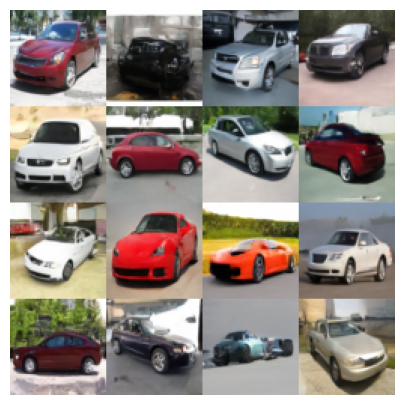

In [14]:
fig, sub = plt.subplots(figsize=(5, 5))
sub.imshow(
    np.transpose(
        make_grid(
            imgs, 
            padding=0,
            normalize=True,
            nrow=4,
        ).cpu(),
        (1,2,0)
    )
)
_ = sub.axis("off")